In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# import dictys
# from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math
import seaborn as sns
# from utils_custom import *

In [2]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'

## Plot cell state distributions per fate

In [44]:
# load cell_count_per_window_df from csv file
cell_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'cell_count_per_window_df.csv'), header=0, index_col=0)
day_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'day_count_per_window_df.csv'), header=0, index_col=0)
pseudotime_values_of_windows = pd.read_csv(os.path.join(input_folder, 'pseudotime_values_of_windows.csv'), header=None)[0].tolist()
cell_count_per_window_df.columns = cell_count_per_window_df.columns.astype(int)
day_count_per_window_df.columns = day_count_per_window_df.columns.astype(int)

In [46]:
# assign window indices to bifurcation branches
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}
colors_day_count = {
    'day0_2': '#87CEFA',     # lightskyblue
    'day3_4': '#1E90FF',     # dodgerblue
    'day5_6': '#00008B'
}

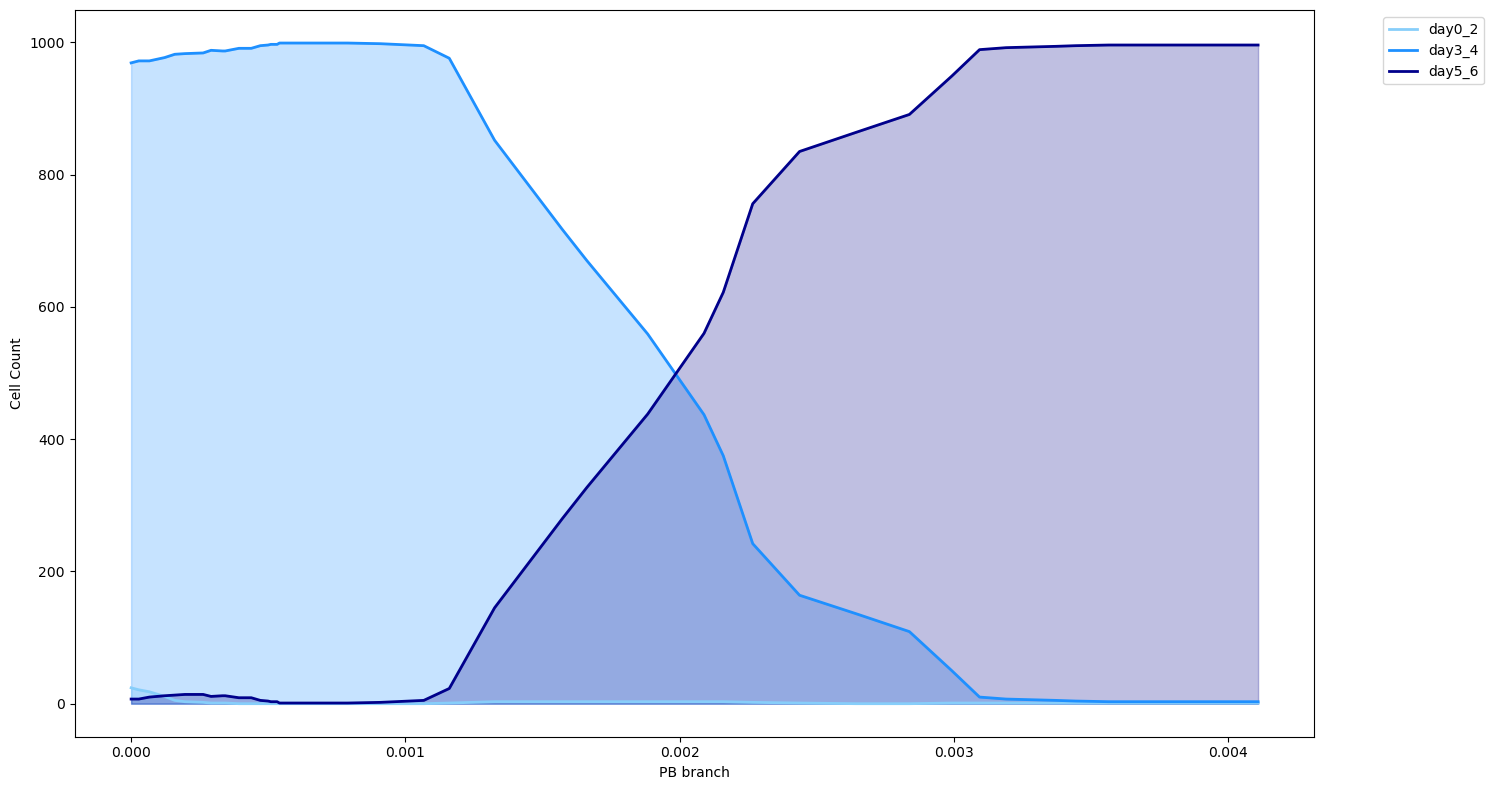

In [49]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = day_count_per_window_df[PB_post_bifurcation_window_indices]

# Plot
plt.figure(figsize=(15, 8))
plt.style.use('default')
plt.grid(False)

# Create x-axis positions
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]

for state in df_plot.index:
    y = df_plot.loc[state]
    line = plt.plot(x, y,
                    label=state,
                    color=colors_day_count[state],
                    linewidth=2)
    # shade under curve
    plt.fill_between(x, y,
                     color=colors_day_count[state],
                     alpha=0.25)      # adjust alpha for desired lightness

plt.xlabel('PB branch')
plt.ylabel('Cell Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/day_count_per_window_PB.pdf', 
            bbox_inches='tight', 
            dpi=100,
            format='pdf')
plt.show()

# Plot pre-dispositions of cells towards GC fate

In [4]:
day2_pro_gc_df = pd.read_csv(os.path.join(input_folder,'pro_GC_df_day2.csv'))
day4_pro_gc_df = pd.read_csv(os.path.join(input_folder,'pro_GC_df_day4.csv'))

day2_pro_gc_df['predisposition'] = np.where(
    day2_pro_gc_df[['D2_per_PRDM1', 'D2_per_IRF4']].notna().any(axis=1),
    'pro-GC',
    'background'
)
day4_pro_gc_df['predisposition'] = np.where(
    day4_pro_gc_df[['D4_per_PRDM1', 'D4_per_IRF4']].notna().any(axis=1),
    'pro-GC',
    'background'
)

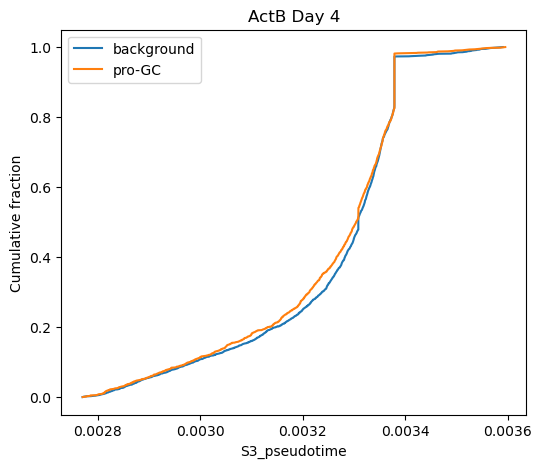

In [16]:
lower = day4_pro_gc_df['S3_pseudotime'].quantile(0.01)
upper = day4_pro_gc_df['S3_pseudotime'].quantile(0.99)
df_no_outliers = day4_pro_gc_df[(day4_pro_gc_df['S3_pseudotime'] >= lower) & (day4_pro_gc_df['S3_pseudotime'] <= upper)]

plt.figure(figsize=(6,5))
for group, group_df in df_no_outliers.groupby('predisposition'):
    sorted_vals = np.sort(group_df['S3_pseudotime'])
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf, label=group)
plt.xlabel('S3_pseudotime')
plt.ylabel('Cumulative fraction')
plt.legend()
plt.title('ActB Day 4')
plt.show()

In [17]:
from scipy.stats import mannwhitneyu

group1 = df_no_outliers[df_no_outliers['predisposition'] == 'pro-GC']['S3_pseudotime']
group2 = df_no_outliers[df_no_outliers['predisposition'] == 'background']['S3_pseudotime']
stat, p = mannwhitneyu(group1, group2)
print(f'Mann-Whitney U test p-value: {p:.3e}')

Mann-Whitney U test p-value: 5.684e-02


# Enriched regulons from static GRN analysis and plotting

In [3]:
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

#### Load enriched link as per state

In [4]:
#Red = PB, Blue = GC
state_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/gene_colors.csv'
enriched_links_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_7_3_GC_PB.csv'
# store the state_LF in a df
state_LF = pd.read_csv(state_LF_file)
enriched_links = pd.read_csv(enriched_links_file)

In [5]:
def create_enriched_links_per_state(enriched_links, state_LF):
    # Create dictionaries to map genes to their states
    gene_to_state = dict(zip(state_LF['gene'], state_LF['color']))

    # Initialize lists to store links for each state
    state1_links = []  # For Red (PB)
    state2_links = []  # For Blue (GC)
    TFs = set()
    targets_in_lf = set()

    # Iterate over each row in the enriched_links DataFrame
    for _, row in enriched_links.iterrows():
        tf_str = row['TF']
        # Extract the TF name from the string representation of a tuple
        tf = tf_str.strip("(,)' ").replace("'", "")
        TFs.add(tf)
        
        # Handle the targets as a string representation of a list
        if isinstance(row['common'], str):
            # If it's a string representation of a list, convert it to a list
            targets_str = row['common'].strip("[]").replace("'", "")
            targets = [t.strip() for t in targets_str.split(",")]
        else:
            # If it's already a list
            targets = row['common']
    
        # Assign each TF-target pair to the appropriate state
        for target in targets:
            if target and target in gene_to_state:
                targets_in_lf.add(target)
                state = gene_to_state[target]
                link = (tf, target)
                if state == 'Red':
                    state1_links.append(link)
                elif state == 'Blue':
                    state2_links.append(link)
    TFs = list(TFs)
    targets_in_lf = list(targets_in_lf)

    return state1_links, state2_links, TFs, targets_in_lf

In [6]:
PB_links, GC_links, TFs, targets_in_lf = create_enriched_links_per_state(enriched_links, state_LF)

In [7]:
# filter the TFs that are not in the dynamic object
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, TFs)
# Remove items that are not in the dynamic object
filtered_TFs = [item for item in TFs if item not in missing_tfs]

#update the GC_links and PB_links
GC_links = [link for link in GC_links if link[0] in filtered_TFs]
PB_links = [link for link in PB_links if link[0] in filtered_TFs]


In [8]:
PB_links_plotting = [('BACH2','XBP1'),('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [63]:
GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]

#### Load the network and get force values (PB/GC)

In [4]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object,varname='w_in')) #varname='w_in' total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [5]:
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 20)

In [6]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 20)

In [14]:
# get target indices 
lf_genes_indices = get_gene_indices(dictys_dynamic_object, targets_in_lf)

In [15]:
# Get the subnetworks for the enriched TFs
filtered_subnetworks = dnet[np.ix_(TF_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(13, 35, 100)

In [16]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in filtered_TFs for target in targets_in_lf]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve.shape)

(455, 100)

#### Slice the enriched links from the entire subnetwork (PB/GC)

In [33]:
enriched_betas = lf_beta_dcurve.loc[GC_links_plotting]
print(enriched_betas.shape)

(12, 100)


#### Get the expression curves for all the TFs (PB/GC)

In [20]:
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")

In [34]:
# get the tf_lcpms for the lineage
tf_list = enriched_betas.index.get_level_values('TF').unique().tolist()
enriched_tfs_lcpm_dcurve = lcpm_dcurve.loc[tf_list]
print(len(enriched_tfs_lcpm_dcurve))

7


In [35]:
lf_forces_dcurve = calculate_force_curves(enriched_betas, enriched_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
IRF4  AFF3   -0.124460 -0.117139 -0.108919 -0.099533 -0.088523 -0.074991   
      PAX5   -0.261816 -0.263228 -0.264746 -0.266377 -0.268132 -0.270018   
NFKB1 AFF3    0.448452  0.453719  0.459129  0.464704  0.470467  0.476443   
      PAX5   -0.266842 -0.269641 -0.272322 -0.274885 -0.277333 -0.279666   
PAX5  PRDM1   0.244662  0.245543  0.246272  0.246846  0.247264  0.247523   

                time_6    time_7    time_8    time_9  ...   time_90   time_91  \
TF    Target                                          ...                       
IRF4  AFF3   -0.056629 -0.017815  0.053623  0.074073  ...  0.200524  0.198302   
      PAX5   -0.272048 -0.274231 -0.276578 -0.279100  ... -0.252371 -0.256441   
NFKB1 AFF3    0.482660  0.489147  0.495938  0.503066  ...  0.640575  0.638897   
      PAX5   -0.281886 -0.283995 -0.285995 -0.287886  ...  0.340137  0.340696   
PAX5  PRDM1   0.247619  0.247552  0.247317  0.246912  ...  0.033245  0.074682   

               time_92   time_93   time_94   time_95   time_96   time_97  \
TF    Target                                                               
IRF4  AFF3    0.196084  0.193870  0.191658  0.189449  0.187243  0.185038   
      PAX5   -0.260340 -0.264075 -0.267654 -0.271084 -0.274372 -0.277523   
NFKB1 AFF3    0.637161  0.635368  0.633518  0.631613  0.629654  0.627643   
      PAX5    0.341164  0.341546  0.341850  0.342081  0.342245  0.342347   
PAX5  PRDM1   0.097071  0.113881  0.127695  0.139566  0.150041  0.159451   

               time_98   time_99  
TF    Target                      
IRF4  AFF3    0.182834  0.180631  
      PAX5   -0.280543 -0.283439  
NFKB1 AFF3    0.625581  0.623471  
      PAX5    0.342392  0.342384  
PAX5  PRDM1   0.168014  0.175881  

[5 rows x 100 columns]

(12, 100)

In [21]:
def plot_force_heatmap_with_clustering(
    force_df: pd.DataFrame,
    dtime: pd.Series,
    regulations=None,
    tf_to_targets_dict=None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    vmax: Optional[float] = None,
    figsize: Tuple[float, float] = (10, 8),
    plot_figure: bool = True,
    perform_clustering: bool = True,
    cluster_method: str = "ward",
    dtop: float = 0,
    dright: float = 0.3,
    row_scaling: dict = None,  # New parameter for scaling specific rows
) -> Tuple[pd.DataFrame, list, pd.Series, Optional[matplotlib.figure.Figure]]:
    """
    Prepares force value data for clustering heatmap and optionally plots it.
    
    Parameters:
    -----------
    row_scaling: Dict[Tuple[str, str], float]
        Dictionary mapping (TF, target) tuples to scaling factors.
        Example: {('IRF4', 'PRDM1'): 0.5} will scale that specific link to 50% of its original values.
    """
    # Process input parameters to generate regulation pairs
    reg_pairs = []
    reg_labels = []
    # Case 1: Dictionary of TF -> targets provided
    if tf_to_targets_dict is not None:
        for tf, targets in tf_to_targets_dict.items():
            for target in targets:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
    # Case 2: List of regulation pairs or list of targets for a single TF
    elif regulations is not None:
        # Check if first item is a string (target) or tuple/list (regulation pair)
        if regulations and isinstance(regulations[0], str):
            # It's a list of targets for a single TF
            # Extract TF name from the calling context (not ideal but works for the notebook)
            for key, value in locals().items():
                if (
                    isinstance(value, dict)
                    and "PRDM1" in value
                    and value["PRDM1"] == regulations
                ):
                    tf = "PRDM1"  # Found the TF
                    break
            else:
                # If we can't determine the TF, use the first item in regulations as TF
                # and the rest as targets (this is a fallback and might not be correct)
                tf = regulations[0]
                regulations = regulations[1:]

            for target in regulations:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
        else:
            # It's a list of regulation pairs
            reg_pairs = regulations
            reg_labels = [f"{tf}->{target}" for tf, target in regulations]
    # If no regulations provided, use non-zero regulations from force_df
    if not reg_pairs:
        non_zero_mask = (force_df != 0).any(axis=1)
        force_df_filtered = force_df[non_zero_mask]
        reg_pairs = list(force_df_filtered.index)
        reg_labels = [f"{tf}->{target}" for tf, target in reg_pairs]
    
    # Extract force values for the specified regulations
    force_values = []
    for pair in reg_pairs:
        tf, target = pair
        try:
            values = force_df.loc[(tf, target)].values
            
            # Apply scaling factor if provided for this pair
            if row_scaling and (tf, target) in row_scaling:
                scale_factor = row_scaling[(tf, target)]
                values = values * scale_factor
                
            force_values.append(values)
        except KeyError:
            raise ValueError(f"Regulation {tf}->{target} not found in force DataFrame")
    
    # Convert to numpy array
    dnet = np.array(force_values)
    
    # Convert dnet to DataFrame with proper labels
    force_df_for_cluster = pd.DataFrame(
        dnet, 
        index=reg_labels,
        columns=[f"{x:.4f}" for x in dtime]
    )
    
    # Plotting logic
    fig = None
    if plot_figure:
        # Calculate max absolute value for symmetric color scaling
        vmax_val = float(force_df_for_cluster.abs().max().max()) if vmax is None else vmax
        
        if perform_clustering:
            # Use cluster_heatmap for visualization
            fig, cols, rows = cluster_heatmap(
                d=force_df_for_cluster,
                optimal_ordering=True,
                method=cluster_method,
                metric="euclidean",
                cmap=cmap,
                aspect=0.1,
                figscale=0.02,
                dtop=dtop,      # Set to > 0 to enable clustering on columns (pseudotime)
                dright=dright,  # Set to > 0 to enable clustering on rows (regulations)
                wcolorbar=0.03,
                wedge=0.03,
                ytick=True,
                vmin=-vmax_val,
                vmax=vmax_val,
                figsize=figsize
            )
            plt.title("Clustered Force Heatmap")
        else:
            # Simple heatmap without clustering
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(dnet, aspect='auto', interpolation='none', cmap=cmap,
                          vmin=-vmax_val, vmax=vmax_val)
            
            # Add colorbar
            cbar = plt.colorbar(im, label="Force")
            
            # Set pseudotime labels as x axis labels
            ax.set_xlabel("Pseudotime")
            num_ticks = 10
            tick_positions = np.linspace(0, dnet.shape[1] - 1, num_ticks, dtype=int)
            tick_labels = dtime.iloc[tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([f"{x:.4f}" for x in tick_labels], rotation=45, ha="right")
            
            # Set regulation pair labels
            ax.set_yticks(list(range(len(reg_labels))))
            ax.set_yticklabels(reg_labels)
            
            # Add grid lines
            ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
            
        plt.tight_layout()
    
    return force_df_for_cluster, reg_labels, dtime, fig

#### Plot the PB/GC links

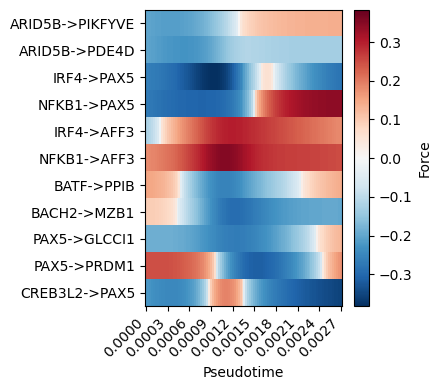

In [70]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this link to 50% of its original values
}

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=GC_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (4.5, 4),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=row_scaling
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/enriched_links_GC.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()


## Selecting the links for plotting

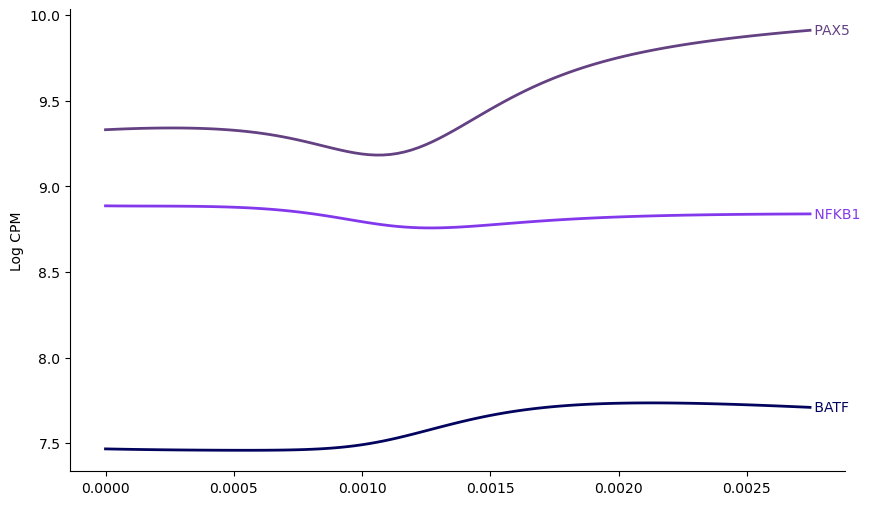

In [22]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
# genes_1 = ['IRF4', 'CREB3L2', 'PRDM1','BACH2', 'RUNX2', 'XBP1']
# colors_1 = ['#0077b6', '#9d0208', '#f9844a','#644182','#8338ec', '#03045e']

genes_1 = ['IRF4', 'CREB3L2', 'PRDM1']
colors_1 = ['#0077b6', '#9d0208', '#f9844a']
genes_2 = ['PAX5', 'NFKB1', 'BATF']
colors_2 = ['#644182','#8338ec', '#03045e']

for gene, color in zip(genes_2, colors_2):
    if gene in lcpm_dcurve.index:
        line = plt.plot(dtime, lcpm_dcurve.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], lcpm_dcurve.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.ylabel('Log CPM')
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/TF_expression_GC_2nd_wave.pdf', 
            bbox_inches='tight', 
            dpi=100,
            format='pdf')
plt.show()